Train multiple models on transformed features

In [1]:
from statistics import mean, stdev
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, roc_auc_score, precision_score, recall_score, accuracy_score,
                             roc_curve, precision_recall_curve,)

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from functions.data import numerical_features, make_confusion_matrix
from functions.plotting.mpl import plot_empty, plot_heatmap, plot_barh

In [2]:
save=True

# Get Data

In [3]:
# Import
records_df = pd.read_csv('data/physics.csv')
transforms_df = pd.read_csv('data/physics-transforms.csv')
df = records_df.join(transforms_df.set_index('id_'), on='id_', how='left')
df = df[numerical_features]

# Features and K-Fold

In [4]:
# Choose features
features_list = ['gpa', 'gpa_sq', 'gre_verbal', 'gre_quantitative', 'gre_writing_pctl', 'gre_subject', 'grev_x_gres',
                 'american', 'papers', 'research',]
target = 'decision'

In [5]:
# Used for K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
scaler = StandardScaler()
ros = RandomOverSampler(random_state=0)

# For comparing models at the end of the notebook
models_list = ['GaussianNB', 'Logistic Regression', 'SVC', 'XGBoost', 'Random Forest']
cv_roc_auc_score_list = []
cv_roc_auc_error_list = []

In [6]:
# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(
    df.drop(columns = [target]), df[target], test_size=.2, random_state=42)

features_train_chosen_df = features_train_all_df[features_list]
features_test_chosen_df = features_test_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
target_train_array = np.array(target_train_ser)

# Gaussian Naive Bayes

In [7]:
# Gaussian Naive Bayes
gnb_clf = GaussianNB()

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    gnb_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(gnb_clf.predict(features_val_cv_scaled_array), target_val_cv_array, average = 'micro')) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, gnb_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('train_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('train_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

cv_roc_auc_score_list.append(mean(roc_auc_list))
cv_roc_auc_error_list.append(stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

gnb_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
gnb_fpr, gnb_tpr, gnb_thresholds = roc_curve(target_test_ser, gnb_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test_f1_score = ", f1_score(gnb_clf.predict(features_test_scaled_array), target_test_ser, average = 'micro'))
print("test_roc_auc_score = ", roc_auc_score(target_test_ser, gnb_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test_accuracy_score = ", accuracy_score(target_test_ser, gnb_clf.predict(features_test_scaled_array)))

train_f1_score:  0.5498210803432138  +/-  0.016848321598993243
train_roc_auc_score:  0.5925776218216269  +/-  0.02152071394241351
test_f1_score =  0.5755305867665418
test_roc_auc_score =  0.6231508459528068
test_accuracy_score =  0.5755305867665418


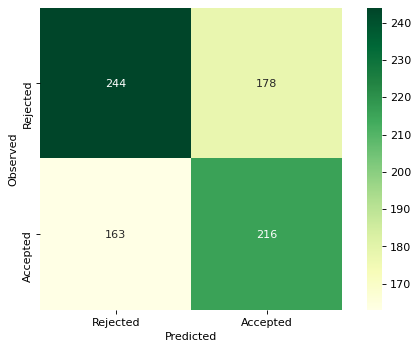

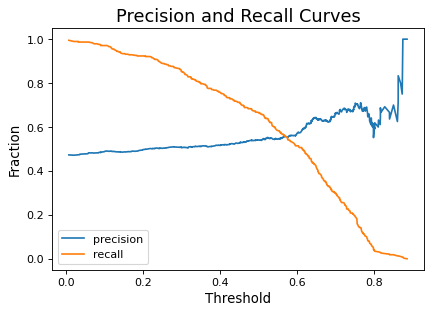

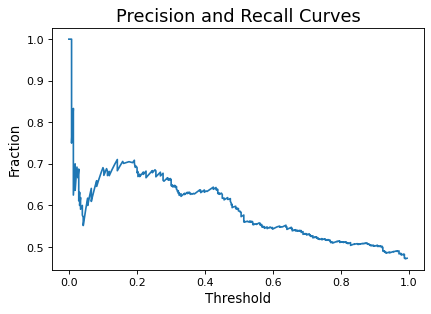

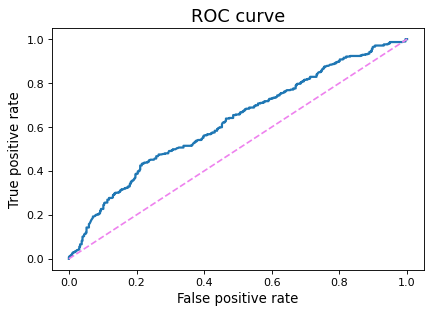

In [8]:
# Confusion Matrix
confusion = make_confusion_matrix(gnb_clf, features_test_scaled_array, target_test_ser, threshold=0.56)
fig, ax = plot_heatmap(confusion,
                       xlabel='Predicted', ylabel='Observed',
                       xticklabels=['Rejected', 'Accepted'],
                       yticklabels=['Rejected', 'Accepted'],
                       color='YlGn'
                      )
if save:
    plt.savefig("figures/gnb/confusion.png", transparent=True, bbox_inches="tight")


# Precision and recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(target_test_ser, gnb_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')

if save:
    plt.savefig("figures/gnb/precision-and-recall.png", transparent=True, bbox_inches="tight")


# Precision-recall curve
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
if save:
    plt.savefig("figures/gnb/precision-recall.png", transparent=True, bbox_inches="tight")
    
    
# ROC Curve
fpr, tpr, thresholds = roc_curve(target_test_ser, gnb_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='False positive rate', ylabel='True positive rate', title='ROC curve', figsize=None)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
if save:
    plt.savefig("figures/gnb/roc.png", transparent=True, bbox_inches="tight")

# Logistic Regression

In [9]:
# Logistic Regression
logreg_clf = LogisticRegression(C=1e9)

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    logreg_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(logreg_clf.predict(features_val_cv_scaled_array), target_val_cv_array, average = 'micro')) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, logreg_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('train_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('train_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

cv_roc_auc_score_list.append(mean(roc_auc_list))
cv_roc_auc_error_list.append(stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

logreg_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
logreg_fpr, logreg_tpr, logreg_thresholds = roc_curve(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test_f1_score = ", f1_score(logreg_clf.predict(features_test_scaled_array), target_test_ser, average = 'micro'))
print("test_roc_auc_score = ", roc_auc_score(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1]))
#print("test accuracy score = ", accuracy_score(target_test_ser, logreg_clf_clf.predict(features_test_scaled_array)))

train_f1_score:  0.567938767550702  +/-  0.0160023456001789
train_roc_auc_score:  0.599494818073607  +/-  0.019696114478304556
test_f1_score =  0.5767790262172284
test_roc_auc_score =  0.6297534044442221


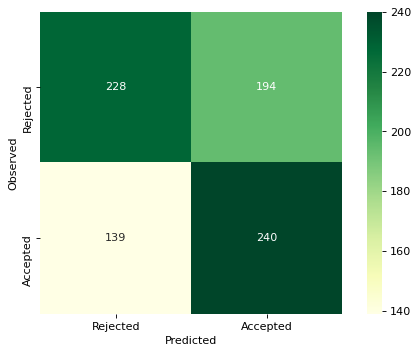

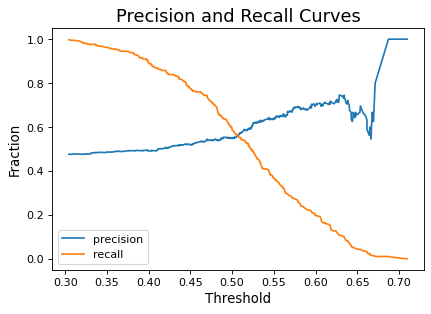

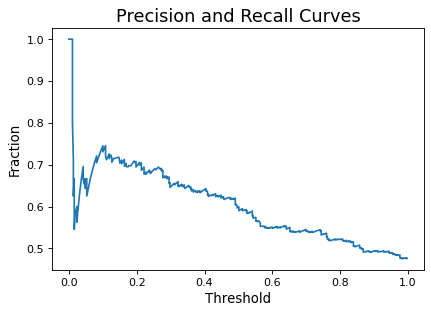

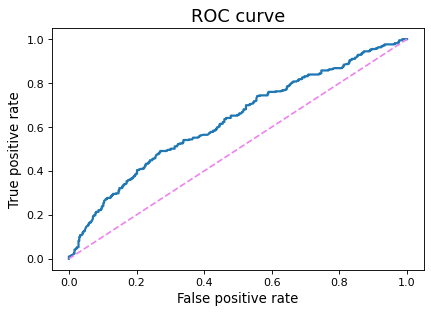

In [10]:
# Confusion Matrix
confusion = make_confusion_matrix(logreg_clf, features_test_scaled_array, target_test_ser, threshold=0.493)
fig, ax = plot_heatmap(confusion,
                       xlabel='Predicted', ylabel='Observed',
                       xticklabels=['Rejected', 'Accepted'],
                       yticklabels=['Rejected', 'Accepted'],
                       color='YlGn'
                      )
if save:
    plt.savefig("figures/logistic-regression/confusion.png", transparent=True, bbox_inches="tight")


# Precision and recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')

if save:
    plt.savefig("figures/logistic-regression/precision-and-recall.png", transparent=True, bbox_inches="tight")


# Precision-recall curve
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
if save:
    plt.savefig("figures/logistic-regression/precision-recall.png", transparent=True, bbox_inches="tight")
    
    
# ROC Curve
fpr, tpr, thresholds = roc_curve(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='False positive rate', ylabel='True positive rate', title='ROC curve', figsize=None)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
if save:
    plt.savefig("figures/logistic-regression/roc.png", transparent=True, bbox_inches="tight")

# Support Vector Machine

In [11]:
# Support Vector Machines
svc_clf = SVC(probability=True, class_weight = 'balanced')

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    svc_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(svc_clf.predict(features_val_cv_scaled_array), target_val_cv_array, average = 'micro')) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, svc_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('train_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('train_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

cv_roc_auc_score_list.append(mean(roc_auc_list))
cv_roc_auc_error_list.append(stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

svc_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
svc_fpr, svc_tpr, svc_thresholds = roc_curve(target_test_ser, svc_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test_f1_score = ", f1_score(svc_clf.predict(features_test_scaled_array), target_test_ser, average = 'micro'))
print("test_roc_auc_score = ", roc_auc_score(target_test_ser, svc_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test_accuracy_score = ", accuracy_score(target_test_ser, svc_clf.predict(features_test_scaled_array)))

train_f1_score:  0.5873113299531981  +/-  0.013554388827397713
train_roc_auc_score:  0.6165901529218745  +/-  0.008277854396939907
test_f1_score =  0.616729088639201
test_roc_auc_score =  0.6522464955170129
test_accuracy_score =  0.616729088639201


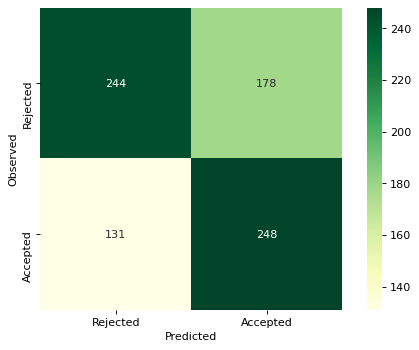

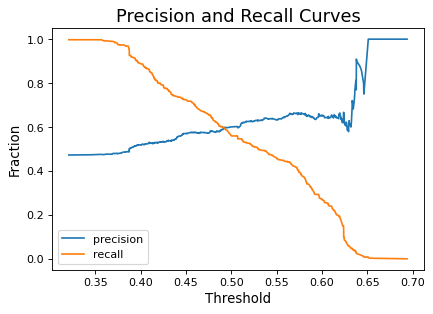

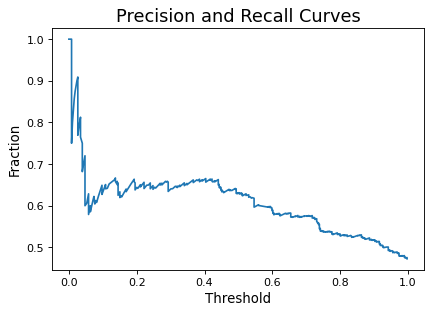

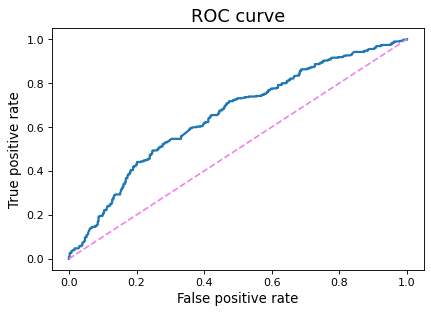

In [12]:
# Confusion Matrix
confusion = make_confusion_matrix(svc_clf, features_test_scaled_array, target_test_ser, threshold=0.477)
fig, ax = plot_heatmap(confusion,
                       xlabel='Predicted', ylabel='Observed',
                       xticklabels=['Rejected', 'Accepted'],
                       yticklabels=['Rejected', 'Accepted'],
                       color='YlGn'
                      )
if save:
    plt.savefig("figures/svc/confusion.png", transparent=True, bbox_inches="tight")


# Precision and recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(target_test_ser, svc_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')

if save:
    plt.savefig("figures/svc/precision-and-recall.png", transparent=True, bbox_inches="tight")


# Precision-recall curve
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
if save:
    plt.savefig("figures/svc/precision-recall.png", transparent=True, bbox_inches="tight")
    
    
# ROC Curve
fpr, tpr, thresholds = roc_curve(target_test_ser, svc_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='False positive rate', ylabel='True positive rate', title='ROC curve', figsize=None)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
if save:
    plt.savefig("figures/svc/roc.png", transparent=True, bbox_inches="tight")

# XGBoost

In [13]:
# XGBoost
xgb_clf = XGBClassifier()

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    xgb_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(xgb_clf.predict(features_val_cv_scaled_array), target_val_cv_array, average = 'micro')) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, xgb_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('train_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('train_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

cv_roc_auc_score_list.append(mean(roc_auc_list))
cv_roc_auc_error_list.append(stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

xgb_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(target_test_ser, xgb_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test_f1_score = ", f1_score(xgb_clf.predict(features_test_scaled_array), target_test_ser, average = 'micro'))
print("test_roc_auc_score = ", roc_auc_score(target_test_ser, xgb_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test_accuracy_score = ", accuracy_score(target_test_ser, xgb_clf.predict(features_test_scaled_array)))

train_f1_score:  0.6332439547581903  +/-  0.020550169985307083
train_roc_auc_score:  0.6686860991720062  +/-  0.0174382885140623
test_f1_score =  0.6329588014981273
test_roc_auc_score =  0.6828270954995059
test_accuracy_score =  0.6329588014981273


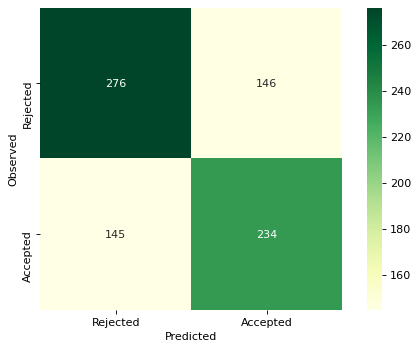

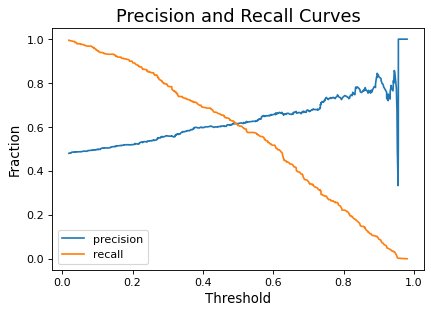

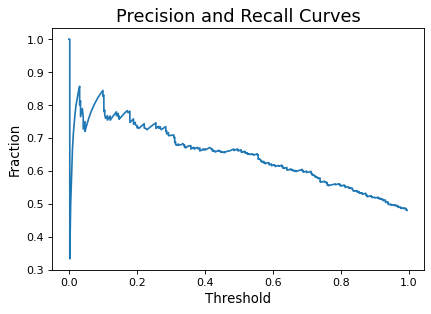

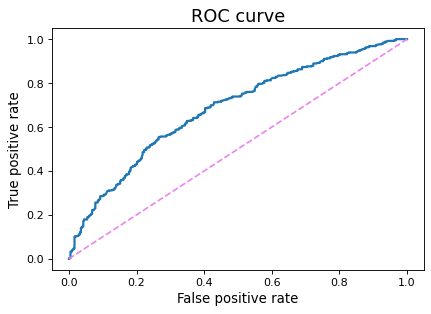

In [14]:
# Confusion Matrix
confusion = make_confusion_matrix(xgb_clf, features_test_scaled_array, target_test_ser, threshold=0.4929)
fig, ax = plot_heatmap(confusion,
                       xlabel='Predicted', ylabel='Observed',
                       xticklabels=['Rejected', 'Accepted'],
                       yticklabels=['Rejected', 'Accepted'],
                       color='YlGn'
                      )
if save:
    plt.savefig("figures/xgboost/confusion.png", transparent=True, bbox_inches="tight")


# Precision and recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(target_test_ser, xgb_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')

if save:
    plt.savefig("figures/xgboost/precision-and-recall.png", transparent=True, bbox_inches="tight")


# Precision-recall curve
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
if save:
    plt.savefig("figures/xgboost/precision-recall.png", transparent=True, bbox_inches="tight")
    
    
# ROC Curve
fpr, tpr, thresholds = roc_curve(target_test_ser, xgb_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='False positive rate', ylabel='True positive rate', title='ROC curve', figsize=None)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
if save:
    plt.savefig("figures/xgboost/roc.png", transparent=True, bbox_inches="tight")

# Random Forest

In [15]:
# Choose features. These are better specifically for random forest, which is insensitive to duplicated/derived features
features_list = ['gpa', 'gre_verbal', 'gre_quantitative', 'gre_writing_pctl', 'gre_subject',
                 'american', 'papers', 'research',]

In [16]:
# Set aside 20% of data for final test
features_train_chosen_df = features_train_all_df[features_list]
features_test_chosen_df = features_test_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
target_train_array = np.array(target_train_ser)

In [17]:
# Random Forest
rf_clf = RandomForestClassifier(random_state = 71)

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):

    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features

    rf_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(rf_clf.predict(features_val_cv_scaled_array), target_val_cv_array, average = 'micro')) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, rf_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('train_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('train_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

cv_roc_auc_score_list.append(mean(roc_auc_list))
cv_roc_auc_error_list.append(stdev(roc_auc_list))

rf_clf = RandomForestClassifier(random_state = 70)

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

rf_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test_f1_score = ", f1_score(rf_clf.predict(features_test_scaled_array), target_test_ser, average = 'micro'))
print("test_roc_auc_score = ", roc_auc_score(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test_accuracy_score = ", accuracy_score(target_test_ser, rf_clf.predict(features_test_scaled_array)))

train_f1_score:  0.6260647425897036  +/-  0.02371891750010803
train_roc_auc_score:  0.6774378826953819  +/-  0.01887994226495785
test_f1_score =  0.6566791510611736
test_roc_auc_score =  0.7057516037464517
test_accuracy_score =  0.6566791510611736


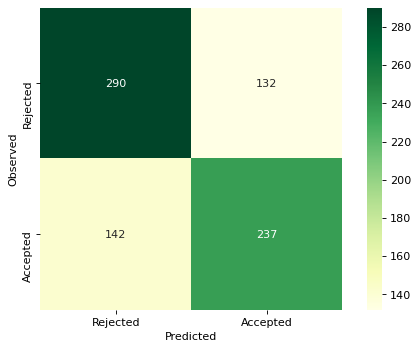

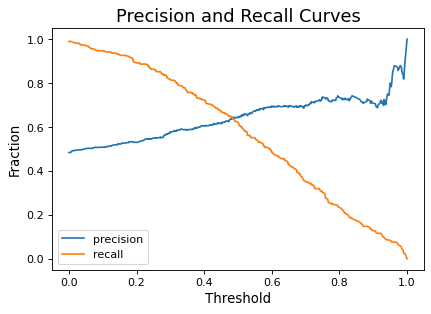

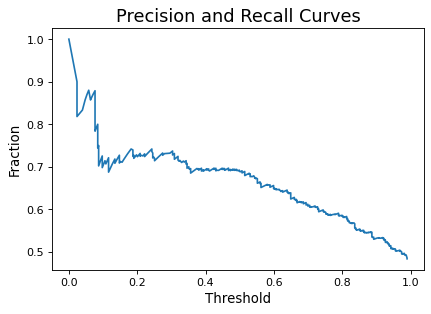

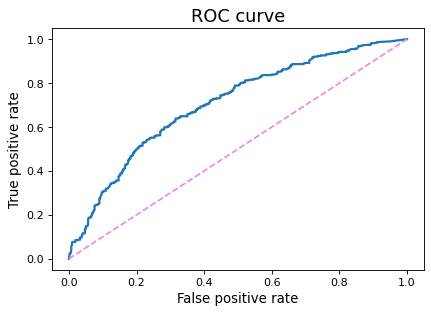

In [18]:
# Confusion Matrix
confusion = make_confusion_matrix(rf_clf, features_test_scaled_array, target_test_ser, threshold=0.4929)
fig, ax = plot_heatmap(confusion,
                       xlabel='Predicted', ylabel='Observed',
                       xticklabels=['Rejected', 'Accepted'],
                       yticklabels=['Rejected', 'Accepted'],
                       color='YlGn'
                      )
if save:
    plt.savefig("figures/random-forest/confusion.png", transparent=True, bbox_inches="tight")


# Precision and recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')

if save:
    plt.savefig("figures/random-forest/precision-and-recall.png", transparent=True, bbox_inches="tight")


# Precision-recall curve
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
if save:
    plt.savefig("figures/random-forest/precision-recall.png", transparent=True, bbox_inches="tight")
    
    
# ROC Curve
fpr, tpr, thresholds = roc_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='False positive rate', ylabel='True positive rate', title='ROC curve', figsize=None)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
if save:
    plt.savefig("figures/random-forest/roc.png", transparent=True, bbox_inches="tight")

# Compare Models

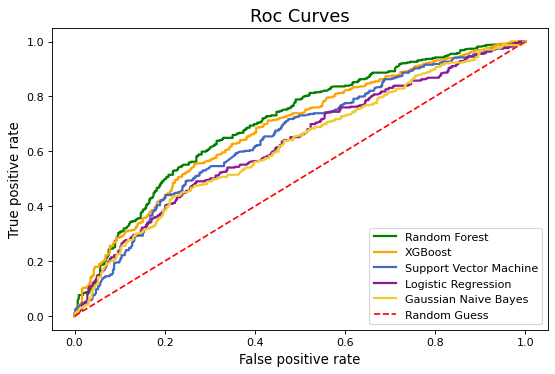

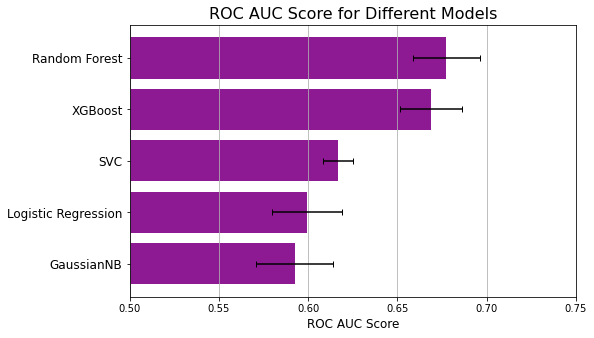

In [19]:
# Roc Curves
fig = plot_empty(xlabel='False positive rate', ylabel='True positive rate', title='Roc Curves')
plt.plot(rf_fpr, rf_tpr, lw=2, color='green', label='Random Forest')
plt.plot(xgb_fpr, xgb_tpr, lw=2, color='#ffa500', label='XGBoost')
plt.plot(svc_fpr, svc_tpr, lw=2, color='#4568c2', label='Support Vector Machine')
plt.plot(logreg_fpr, logreg_tpr, lw=2, color='#8d1a93', label='Logistic Regression')
plt.plot(gnb_fpr, gnb_tpr, lw=2, color='#f0cb2f', label='Gaussian Naive Bayes')
plt.plot([0,1],[0,1],c='red',ls='--', label='Random Guess')
plt.rcParams.update({'axes.labelsize': 12,
                     'axes.titlesize': 16,})
plt.legend(loc='lower right')
if save:
    plt.savefig("figures/roc.png", transparent=True, bbox_inches="tight")
    

# Roc AUC Bar
bar_df = pd.DataFrame({'x': cv_roc_auc_score_list[0:5],
                       'y': models_list,
                       'err': cv_roc_auc_error_list[0:5]})
fig, ax = plot_barh(bar_df, 'x', 'y', xerr='err',
                xlabel='ROC AUC Score',
                title='ROC AUC Score for Different Models')
ax.set_xlim(left = 0.5, right = 0.75)
ax.xaxis.grid(True)
if save:
    plt.savefig("figures/roc-bar.png", transparent=True, bbox_inches="tight")